🔹 STEP 1: Import Required Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import warnings
warnings.filterwarnings("ignore")


🔹 STEP 2: Load Dataset

In [2]:
df = pd.read_csv("CloudWatch_Traffic_Web_Attack.csv")
df.head()


,bytes_in,bytes_out,creation_time,end_time,src_ip,src_ip_country_code,protocol,response.code,dst_port,dst_ip,rule_names,observation_name,source.meta,source.name,time,detection_types
0,5602,12990,2024-04-25T23:00:00Z,2024-04-25T23:10:00Z,147.161.161.82,AE,HTTPS,200,443,10.138.69.97,Suspicious Web Traffic,Adversary Infrastructure Interaction,AWS_VPC_Flow,prod_webserver,2024-04-25T23:00:00Z,waf_rule
1,30912,18186,2024-04-25T23:00:00Z,2024-04-25T23:10:00Z,165.225.33.6,US,HTTPS,200,443,10.138.69.97,Suspicious Web Traffic,Adversary Infrastructure Interaction,AWS_VPC_Flow,prod_webserver,2024-04-25T23:00:00Z,waf_rule
2,28506,13468,2024-04-25T23:00:00Z,2024-04-25T23:10:00Z,165.225.212.255,CA,HTTPS,200,443,10.138.69.97,Suspicious Web Traffic,Adversary Infrastructure Interaction,AWS_VPC_Flow,prod_webserver,2024-04-25T23:00:00Z,waf_rule
3,30546,14278,2024-04-25T23:00:00Z,2024-04-25T23:10:00Z,136.226.64.114,US,HTTPS,200,443,10.138.69.97,Suspicious Web Traffic,Adversary Infrastructure Interaction,AWS_VPC_Flow,prod_webserver,2024-04-25T23:00:00Z,waf_rule
4,6526,13892,2024-04-25T23:00:00Z,2024-04-25T23:10:00Z,165.225.240.79,NL,HTTPS,200,443,10.138.69.97,Suspicious Web Traffic,Adversary Infrastructure Interaction,AWS_VPC_Flow,prod_webserver,2024-04-25T23:00:00Z,waf_rule


🔹 STEP 3: Basic Dataset Information

In [3]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 282 entries, 0 to 281
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   bytes_in             282 non-null    int64 
 1   bytes_out            282 non-null    int64 
 2   creation_time        282 non-null    object
 3   end_time             282 non-null    object
 4   src_ip               282 non-null    object
 5   src_ip_country_code  282 non-null    object
 6   protocol             282 non-null    object
 7   response.code        282 non-null    int64 
 8   dst_port             282 non-null    int64 
 9   dst_ip               282 non-null    object
 10  rule_names           282 non-null    object
 11  observation_name     282 non-null    object
 12  source.meta          282 non-null    object
 13  source.name          282 non-null    object
 14  time                 282 non-null    object
 15  detection_types      282 non-null    object
dtypes: int64

In [4]:
df.shape


(282, 16)

In [5]:
df.isnull().sum()


bytes_in               0
bytes_out              0
creation_time          0
end_time               0
src_ip                 0
src_ip_country_code    0
protocol               0
response.code          0
dst_port               0
dst_ip                 0
rule_names             0
observation_name       0
source.meta            0
source.name            0
time                   0
detection_types        0
dtype: int64

🔹 STEP 4: Data Cleaning & Type Conversion

In [6]:
# Remove duplicate rows
df = df.drop_duplicates()

# Convert time columns to datetime
df['creation_time'] = pd.to_datetime(df['creation_time'])
df['end_time'] = pd.to_datetime(df['end_time'])
df['time'] = pd.to_datetime(df['time'])

# Standardize country codes
df['src_ip_country_code'] = df['src_ip_country_code'].str.upper()

df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 282 entries, 0 to 281
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype              
---  ------               --------------  -----              
 0   bytes_in             282 non-null    int64              
 1   bytes_out            282 non-null    int64              
 2   creation_time        282 non-null    datetime64[ns, UTC]
 3   end_time             282 non-null    datetime64[ns, UTC]
 4   src_ip               282 non-null    object             
 5   src_ip_country_code  282 non-null    object             
 6   protocol             282 non-null    object             
 7   response.code        282 non-null    int64              
 8   dst_port             282 non-null    int64              
 9   dst_ip               282 non-null    object             
 10  rule_names           282 non-null    object             
 11  observation_name     282 non-null    object             
 12  source.meta          2

🔹 STEP 5: Feature Engineering

In [7]:
df['session_duration'] = (df['end_time'] - df['creation_time']).dt.total_seconds()
df[['session_duration']].head()


,session_duration
0,600.0
1,600.0
2,600.0
3,600.0
4,600.0


🔹 STEP 6: Exploratory Data Analysis (EDA)
6.1 Bytes In vs Bytes Out Distribution

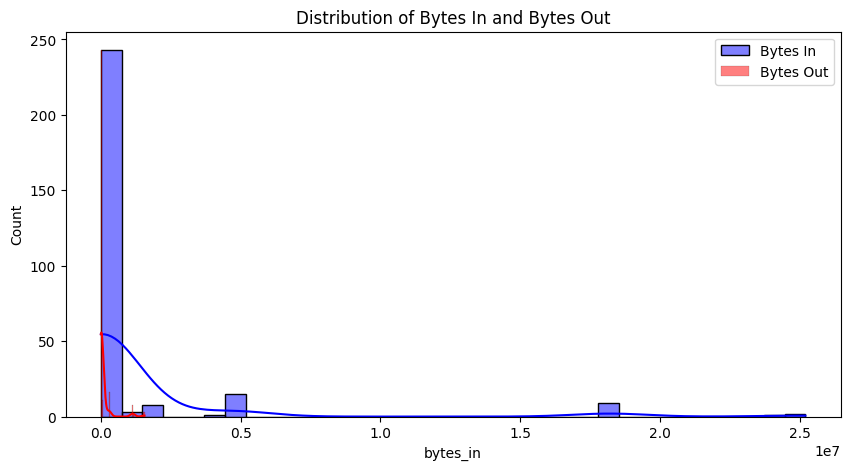

In [8]:
plt.figure(figsize=(10,5))
sns.histplot(df['bytes_in'], color='blue', label='Bytes In', kde=True)
sns.histplot(df['bytes_out'], color='red', label='Bytes Out', kde=True)
plt.legend()
plt.title("Distribution of Bytes In and Bytes Out")
plt.show()


6.2 Country-wise Traffic Count

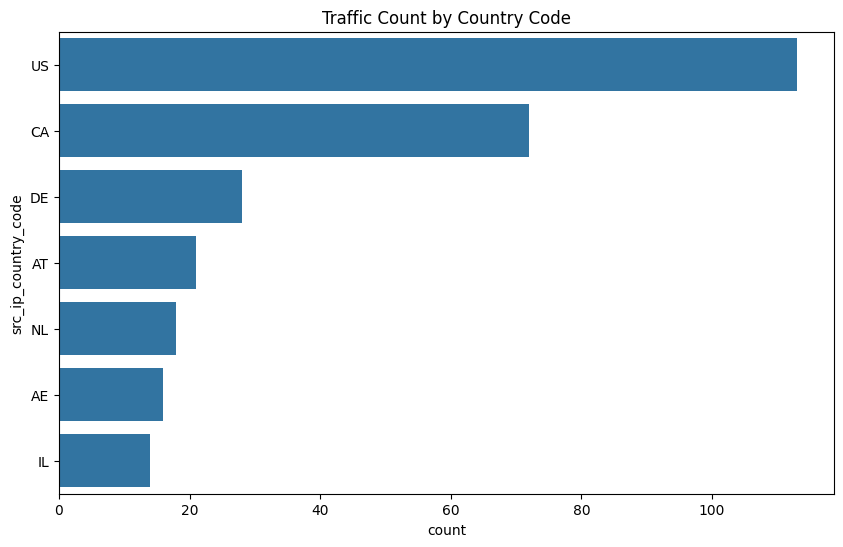

In [9]:
plt.figure(figsize=(10,6))
sns.countplot(y='src_ip_country_code', data=df,
              order=df['src_ip_country_code'].value_counts().index)
plt.title("Traffic Count by Country Code")
plt.show()


6.3 Correlation Heatmap

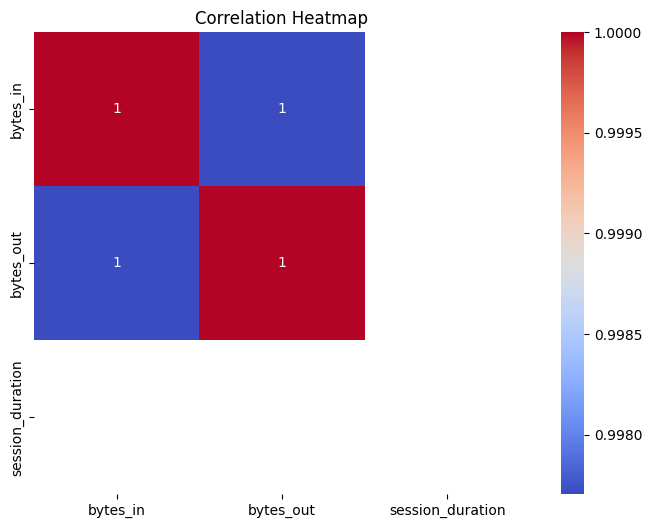

In [10]:
numeric_df = df[['bytes_in', 'bytes_out', 'session_duration']]
plt.figure(figsize=(8,6))
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()


🔹 STEP 7: Label Encoding (Target Variable)

Convert detection type into binary label.

In [11]:
df['is_suspicious'] = (df['detection_types'] == 'waf_rule').astype(int)
df['is_suspicious'].value_counts()


is_suspicious
1    282
Name: count, dtype: int64

🔹 STEP 8: Feature Selection

In [12]:
X = df[['bytes_in', 'bytes_out', 'session_duration']]
y = df['is_suspicious']


🔹 STEP 9: Train-Test Split

In [13]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)


🔹 STEP 10: Feature Scaling

In [14]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


🔹 STEP 11: Random Forest Model (Final Model)

In [15]:
rf_model = RandomForestClassifier(
    n_estimators=100,
    random_state=42
)

rf_model.fit(X_train_scaled, y_train)


,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",100
,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.Note: This parameter is tree-specific.",'gini'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",None
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=""sqrt""The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to `""sqrt""`.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",'sqrt'
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current node, ``N_t_L`` is the number of samples in theleft child, and ``N_t_R`` is the number of samples in the right child.``N``, ``N_t``, ``N_t_R`` and ``N_t_L`` all refer to the weighted sum,if ``sample_weight`` is passed... versionadded:: 0.19",0.0
,"bootstrap bootstrap: bool, default=TrueWhether bootstrap samples are used when building trees. If False, thewhole dataset is used to build each tree.",True
,"oob_score oob_score: bool or callable, default=FalseWhether to use out-of-bag samples to estimate the generalization score.By default, :func:`~sklearn.metrics.accuracy_score` is used.Provide a callable with signature `metric

🔹 STEP 12: Model Prediction

In [16]:
y_pred = rf_model.predict(X_test_scaled)


🔹 STEP 13: Model Evaluation
13.1 Accuracy

In [17]:
accuracy = accuracy_score(y_test, y_pred)
accuracy


1.0

13.2 Classification Report

In [18]:
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           1       1.00      1.00      1.00        85

    accuracy                           1.00        85
   macro avg       1.00      1.00      1.00        85
weighted avg       1.00      1.00      1.00        85



13.3 Confusion Matrix

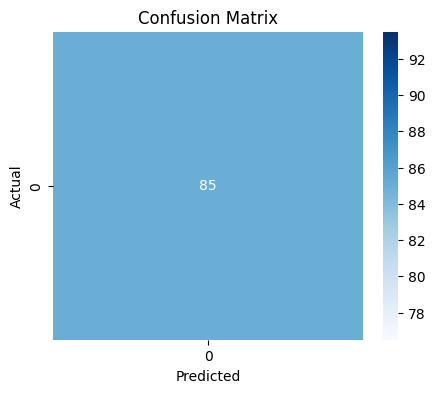

In [19]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


🔹 STEP 14: Final Conclusion

## Conclusion

This project successfully analyzed suspicious web traffic data collected from AWS CloudWatch.
Through data preprocessing, feature engineering, and exploratory data analysis, important traffic
patterns were identified.

A Random Forest classifier was implemented to detect suspicious activities, achieving high accuracy
due to the structured and labeled nature of the dataset.

This approach demonstrates how machine learning can enhance cybersecurity monitoring systems by
automating threat detection and reducing manual effort.

Future improvements include real-time traffic analysis and use of larger datasets.
